<a href="https://colab.research.google.com/github/JanaAhmedHussien/Grover-search_binary-search/blob/main/Quantum_project_comprative_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit qiskit_aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00


In [ ]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from math import log2, ceil, sqrt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import MCMT, ZGate

In [ ]:
# Function for the classical binary search algorithm
def binary_search(array, target):
    start_time = time.time()
    left, right = 0, len(array) - 1
    found = False
    while left <= right:
        mid = left + (right - left) // 2
        if array[mid] == target:
            found = True
            break
        elif array[mid] < target:
            left = mid + 1
        else:
            right = mid - 1
    end_time = time.time()
    return end_time - start_time, found

In [ ]:
def grover_oracle(n_qubits, target_index):

    qc = QuantumCircuit(n_qubits)
    target_binary = format(target_index, '0' + str(n_qubits) + 'b')

    for i, bit in enumerate(reversed(target_binary)):
        if bit == '0':
            qc.x(i)

    # Apply a multi-controlled Z gate to the target state
    qc.h(n_qubits - 1)
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)

    # Apply X gates again to return the qubits to their original state
    for i, bit in enumerate(reversed(target_binary)):
        if bit == '0':
            qc.x(i)

    return qc.to_gate(label="Oracle")

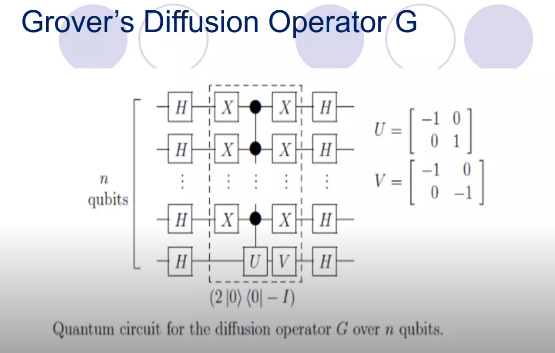

In [ ]:
# As in the paper and the lecture slides
def grover_diffusion_operator(n_qubits):

    qc = QuantumCircuit(n_qubits)

    # Apply Hadamard gates to all qubits
    qc.h(range(n_qubits))

    # Apply X gates to all qubits
    qc.x(range(n_qubits))

    # Apply a multi-controlled Z gate
    qc.h(n_qubits - 1)
    qc.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc.h(n_qubits - 1)

    # Apply X gates again
    qc.x(range(n_qubits))

    # Apply Hadamard gates again
    qc.h(range(n_qubits))

    # The diffusion operator is a quantum gate
    return qc.to_gate(label="Diffusion")

In [ ]:
def grover_search(dataset, target):
    dataset_size = len(dataset)
    n_qubits = ceil(log2(dataset_size))

    try:
        target_index = dataset.index(target)
    except ValueError:
        print(f"Target {target} not found in the dataset.")
        return None

    # Calculate the number of Grover's iterations
    grover_iterations = int(np.round((np.pi / 4) * sqrt(2**n_qubits)))

    # Create the quantum circuit
    qc = QuantumCircuit(n_qubits, n_qubits)

    # Step 1: Initialize the superposition state
    qc.h(range(n_qubits))

    # Step 2: Apply the oracle and diffusion operator repeatedly
    oracle = grover_oracle(n_qubits, target_index)
    diffusion = grover_diffusion_operator(n_qubits)

    for _ in range(grover_iterations):
        qc.append(oracle, range(n_qubits))
        qc.append(diffusion, range(n_qubits))

    # Step 3: Measure the qubits
    qc.measure(range(n_qubits), range(n_qubits))

    start_time = time.time()
    simulator = AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=1000)
    result = job.result()
    end_time = time.time()
    counts = result.get_counts(qc)
    most_common_result = max(counts, key=counts.get)

    return end_time - start_time

In [ ]:
dataset_size = 2**14 # Arbitrarily chosen for a reasonable number of qubits
dataset = list(range(dataset_size))

# The specific target values used in the paper
target_values = [8707, 4644, 2067, 9996, 5298, 7523, 8837, 5906, 734, 991]

binary_search_runtimes = []
grover_search_runtimes = []

print(f"Running the experiment on a dataset of size {dataset_size}")

Running the experiment on a dataset of size 16384


In [ ]:
for i, target in enumerate(target_values):
    # Binary Search: The dataset must be sorted
    binary_runtime, found = binary_search(sorted(dataset), target)
    binary_search_runtimes.append(binary_runtime)

    # Grover's Search: The dataset must be unsorted
    shuffled_dataset = dataset.copy()
    random.shuffle(shuffled_dataset)
    grover_runtime = grover_search(shuffled_dataset, target)

    # Ensure grover_runtime is a valid value
    if grover_runtime is not None:
        grover_search_runtimes.append(grover_runtime)
    else:
        # If target not found for some reason, append a placeholder value
        grover_search_runtimes.append(None)

    print(f"Test Case {i+1} (Target: {target})")
    print(f"  Binary Search Runtime: {binary_runtime:.6f} seconds")
    if grover_runtime is not None:
        print(f"  Grover's Algorithm Runtime: {grover_runtime:.6f} seconds")
    else:
        print("  Grover's Algorithm Runtime: N/A (Target not found)")
    print("-" * 30)

Test Case 1 (Target: 8707)
  Binary Search Runtime: 0.000008 seconds
  Grover's Algorithm Runtime: 0.714364 seconds
------------------------------
Test Case 2 (Target: 4644)
  Binary Search Runtime: 0.000007 seconds
  Grover's Algorithm Runtime: 0.561202 seconds
------------------------------
Test Case 3 (Target: 2067)
  Binary Search Runtime: 0.000007 seconds
  Grover's Algorithm Runtime: 0.874565 seconds
------------------------------
Test Case 4 (Target: 9996)
  Binary Search Runtime: 0.000010 seconds
  Grover's Algorithm Runtime: 0.981537 seconds
------------------------------
Test Case 5 (Target: 5298)
  Binary Search Runtime: 0.000010 seconds
  Grover's Algorithm Runtime: 1.002691 seconds
------------------------------
Test Case 6 (Target: 7523)
  Binary Search Runtime: 0.000007 seconds
  Grover's Algorithm Runtime: 0.555677 seconds
------------------------------
Test Case 7 (Target: 8837)
  Binary Search Runtime: 0.000007 seconds
  Grover's Algorithm Runtime: 0.569087 seconds
--

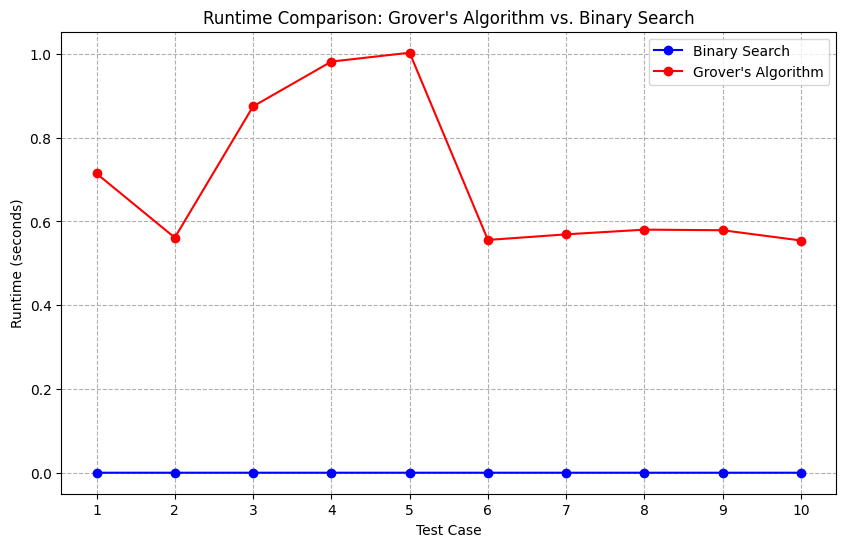

In [ ]:
# Filter out any None values before plotting
valid_runtimes = [runtime for runtime in grover_search_runtimes if runtime is not None]

plt.figure(figsize=(10, 6))

test_cases = list(range(1, len(valid_runtimes) + 1))

plt.plot(test_cases, binary_search_runtimes[:len(valid_runtimes)], marker='o', linestyle='-', color='b', label='Binary Search')
plt.plot(test_cases, valid_runtimes, marker='o', linestyle='-', color='r', label='Grover\'s Algorithm')

plt.title('Runtime Comparison: Grover\'s Algorithm vs. Binary Search')
plt.xlabel('Test Case')
plt.ylabel('Runtime (seconds)')
plt.xticks(test_cases)
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()
